In [1]:
#!pip install git+https://github.com/alan-turing-institute/SigNet.git
# !pip install --upgrade matplotlib
#!python -m pip install basemap

In [2]:
%matplotlib inline
from SBM_attributed import *
from BregmanFramework import *
from copy import deepcopy
from sklearn.metrics import rand_score, calinski_harabasz_score, mutual_info_score, accuracy_score
from signet.cluster import Cluster
import scipy.sparse as ss
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [3]:
c = 3
n = 100
N = c*n
delta = 10
d = 2
dim = c*d
P = np.array([[0.8, 0.2, 0.3],[0.2, 0.7, 0.4],[0.3, 0.4, 0.6]])
true_labels = [0]*n + [1]*n + [2]*n

In [4]:
### Generate benchmark
_,A,X = generate_benchmark(P,c,delta=0,n=n,dim=d,sample_along_direction=True,P_data=P)
# x_min = X.min()
# x_max = X.max()
# X = (X - x_min)/(x_max - x_min)

In [5]:
classifier = BregmanClustering(norm=-2,matrix_norm=False,method='soft',divergence_method='Nelementwise',
                               initialization="spectral",data_divergence="euclidean",net_divergence="euclidean")
W,B,mu=classifier.cluster(A,X,c,maxiter=10,threshold=5,annealing=False)

net_div =  tensor(1.7287) data_div =  tensor(1940.3562)
1
point assignments have converged
net_div =  tensor(2.8538) data_div =  tensor(8910.0410)


In [6]:
pred_labels = np.argmax(W, axis=1)
true_labels = [0]*n + [1]*n + [2]*n
print(rand_score(true_labels, pred_labels),mutual_info_score(true_labels, pred_labels))

1.0 1.0986122886681091


In [7]:
# A = torch.tensor(A,dtype=torch.float32)
# W = torch.tensor(W,dtype=torch.float32)
# Z = W/W.sum(dim=0)
# classifier.pairwise_bregman(A@Z,Z.T@A@Z, classifier.phi_net)

In [8]:
mu

array([[ 0.67, -3.92,  0.12,  2.52, -3.02,  2.04],
       [-0.04,  1.05,  0.47, -0.17,  0.53, -0.52],
       [-0.79,  3.43, -0.24, -2.66,  2.55, -1.71]], dtype=float32)

In [9]:
def spectral(A,k):
    #L = nx.linalg.laplacianmatrix.laplacian_matrix(G).toarray()
    L = csgraph.laplacian(A)
    L = L.astype(np.float32)
    vals = vecs = 0
    vals, vecs = eigs(L, k=(k+1), which='SM', maxiter=5000)
    U = np.delete(vecs,np.argmin(vals),1)
    return KMeans(n_clusters=k).fit_predict(U.real)

In [10]:
pred_labels = spectral(A,c)
print(rand_score(true_labels, pred_labels),mutual_info_score(true_labels, pred_labels))

1.0 1.0986122886681091


## Australia Rainfall 

In [11]:
corr_df=pd.read_csv('data/corr_mat.csv',index_col=0)
stat_lat_lon_df = pd.read_csv('data/stations_coords.csv')
stat_lat_lon_df = stat_lat_lon_df.drop(stat_lat_lon_df.columns[[0]],axis=1)
# Create the signed graph 
corr=corr_df.to_numpy()
# Adjacency matrices (positive and negative)
Ap = (corr + abs(corr))/2.
Am = (abs(corr)- corr)/2.
Aps = ss.csc_matrix(Ap)
Ams = ss.csc_matrix(Am)
# Covariates
X = np.array(stat_lat_lon_df,dtype=float)
x_min = X.min()
x_max = X.max()
X = (X - x_min)/(x_max - x_min)

In [12]:
m = Cluster((Aps, Ams))
k=5
predictions = m.SPONGE(k, tau_p=1, tau_n=1, eigens=None, mi=None)
classifier = BregmanClustering(norm=-np.inf,matrix_norm=False,method='hard',
                               divergence_method='Nelementwise',
                               initialization="spectral")
W,B,mu=classifier.cluster(Ap-Am,X,k,maxiter=100,threshold=5)
predictions2 = np.argmax(W, axis=1)

net_div =  tensor(53.5642) data_div =  tensor(22.1449)
1
point assignments have converged
net_div =  tensor(30.9472) data_div =  tensor(9.4145)


In [13]:
# Sort the adjacency matrices
# Compute the permutation (Sponge)
permut =[]
for i in range(k):
    permut= permut+[j for j in range(306) if predictions[j]==i]

# Sort the adjacency matrices
ssortedp = m.p.todense()[permut,:][:,permut]
ssortedn = m.n.todense()[permut,:][:,permut]

# Compute the permutation (BregmanFramework)
permut2 =[]
for i in range(k):
    permut2= permut2+[j for j in range(306) if predictions2[j]==i]
    
# Sort the adjacency matrices
ssortedp2 = m.p.todense()[permut2,:][:,permut2]
ssortedn2 = m.n.todense()[permut2,:][:,permut2]

In [14]:
stations_a = stat_lat_lon_df[["Station"]]
stations_a = stations_a.to_numpy()
stat_lat_lon_a = stat_lat_lon_df.to_numpy()
cmap = matplotlib.cm.get_cmap('tab10')
markers_ = ['o', 'v', '^', '<', '>',  's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '8']
# input desired coordinates
my_coords = stat_lat_lon_a[0, 1:3]

# How much to zoom from coordinates (in degrees)
zoom_scale = 20

# Setup the bounding box for the zoom and bounds of the map
bbox = [-46, -8, 110, 158]

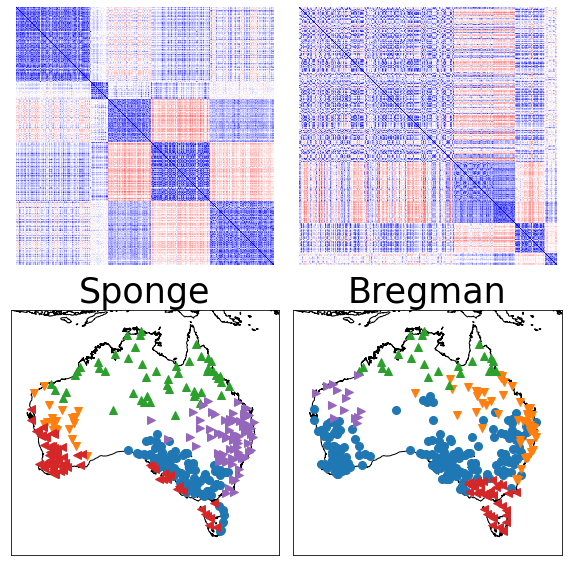

In [15]:
fig, axs = plt.subplots(2, 2,figsize=(8, 8))
axs[0, 0].matshow(ssortedp-ssortedn,cmap='bwr_r',vmin=-1,vmax=1)
axs[0, 0].axis('off')
axs[0, 1].matshow(ssortedp2-ssortedn2,cmap='bwr_r',vmin=-1,vmax=1)
axs[0, 1].axis('off')

#Second line
axs[1, 0].set_title("Sponge",fontsize=35)
grouped_coords = []
for i in range(k):
    i_stations = stations_a[predictions==i]
    i_coords = []
    for s in i_stations:
        idx = np.where(stat_lat_lon_a[:,0] == s)
        i_coords.append(stat_lat_lon_a[idx])
    grouped_coords.append(i_coords)
mm = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',ax=axs[1,0])
# Draw coastlines and fill continents and water with color
mm.drawcoastlines()
colors = ['r', 'g', 'b', 'c', 'y']
markers = []
for i in range(k):
    coords = np.array(grouped_coords[i])[:, 0, 1:3]
    x,y = mm(coords[:,1],coords[:,0])
    mm.plot(x,y, color = cmap(i), markersize=8, lw = 0, marker = markers_[i])
    
axs[1, 1].set_title('Bregman',fontsize=35)
grouped_coords = []
for i in range(k):
    i_stations = stations_a[predictions2==i]
    i_coords = []
    for s in i_stations:
        idx = np.where(stat_lat_lon_a[:,0] == s)
        i_coords.append(stat_lat_lon_a[idx])
    grouped_coords.append(i_coords)
    
mm = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',ax=axs[1,1])

# Draw coastlines and fill continents and water with color
mm.drawcoastlines()
colors = ['r', 'g', 'b', 'c', 'y']
markers = []
for i in range(k):
    coords = np.array(grouped_coords[i])[:, 0, 1:3]
    x,y = mm(coords[:,1],coords[:,0])
    mm.plot(x,y, color = cmap(i), markersize=8, lw = 0, marker = markers_[i])

plt.tight_layout()

In [16]:
rand_score(predictions, predictions2),mutual_info_score(predictions,predictions2)

(0.6281581485053037, 0.503887602220608)

## Equally spaced distributions

In [17]:
pin=0.1
#pouts = np.arange(pout_min,pout_max,0.01)
pouts=[0.01,0.05,0.1]
sigmas=[0.1,1,10]
with open("metrics.txt",'w',encoding = 'utf-8') as f:
    f.write("pout,sigma,RandIndexBregman,StdRandBregman,MutualInfoBregman,StdMutualBregman,\
    RandIndexKmeans,StdRandKmeans,MutualInfoKmeans,StdMutualKmeans,\
    RandIndexSpectral,StdRandSpectral,MutualInfoSpectral,StdMutualSpectral\n")
    for p_net in pouts:
        P_net = np.eye(3)*pin
        P_net[P_net==0] = p_net
        for sigma in sigmas:
            rs_b = []
            mi_b = []
            rs_k = []
            mi_k = []
            rs_s = []
            mi_s = []
            print(sigma,p_net)
            for _ in range(1):
                G,A,X = generate_benchmark_unit_circle(P_net,c,sigma,n,dim,delta=1)
                x_min = X.min()
                x_max = X.max()
                X = (X - x_min)/(x_max - x_min)
                pred_labels = KMeans(n_clusters=c).fit_predict(X)
                rs_k.append(rand_score(true_labels, pred_labels))
                mi_k.append(mutual_info_score(true_labels, pred_labels))
                
                pred_labels = spectral(A,c)
                rs_s.append(rand_score(true_labels, pred_labels))
                mi_s.append(mutual_info_score(true_labels, pred_labels))
                
#                 A = torch.tensor(A,dtype=torch.float32)
#                 X = torch.tensor(X,dtype=torch.float32)
                classifier = BregmanClustering(norm=-2,matrix_norm=False,method='hard',
                                               divergence_method='Nelementwise',
                                               initialization="spectral",
                                               data_divergence="euclidean",
                                               net_divergence="euclidean")
                W,B,mu=classifier.cluster(A,X,c,maxiter=100,threshold=5,annealing=False)
                pred_labels = np.argmax(W, axis=1)
                rs_b.append(rand_score(true_labels, pred_labels))
                mi_b.append(mutual_info_score(true_labels, pred_labels))
            f.write(f"{p_net},{sigma},{np.mean(rs_b)},{np.std(rs_b)},{np.mean(mi_b)},{np.std(mi_b)}\
            ,{np.mean(rs_k)},{np.std(rs_k)},{np.mean(mi_k)},{np.std(mi_k)}\
            ,{np.mean(rs_s)},{np.std(rs_s)},{np.mean(mi_s)},{np.std(mi_s)}\n")

0.1 0.01
net_div =  tensor(0.3269) data_div =  tensor(4.9387)
1
point assignments have converged
net_div =  tensor(0.3242) data_div =  tensor(4.7409)
1 0.01
net_div =  tensor(0.3269) data_div =  tensor(12.0607)
1
point assignments have converged
net_div =  tensor(0.4149) data_div =  tensor(10.9964)
10 0.01
net_div =  tensor(0.3269) data_div =  tensor(14.0649)
1
point assignments have converged
net_div =  tensor(0.3822) data_div =  tensor(13.6752)
0.1 0.05
net_div =  tensor(16.5656) data_div =  tensor(29.6620)
1
point assignments have converged
net_div =  tensor(0.6015) data_div =  tensor(7.9057)
1 0.05
net_div =  tensor(16.5656) data_div =  tensor(17.0520)
1
point assignments have converged
net_div =  tensor(0.7195) data_div =  tensor(10.2107)
10 0.05
net_div =  tensor(16.5656) data_div =  tensor(14.1221)
1
point assignments have converged
net_div =  tensor(0.6910) data_div =  tensor(7.8522)
0.1 0.1
net_div =  tensor(32.1322) data_div =  tensor(25.4422)
1
point assignments have converg

In [18]:
df = pd.read_csv("metrics.txt")
df

,pout,sigma,RandIndexBregman,StdRandBregman,MutualInfoBregman,StdMutualBregman,RandIndexKmeans,StdRandKmeans,MutualInfoKmeans,StdMutualKmeans,RandIndexSpectral,StdRandSpectral,MutualInfoSpectral,StdMutualSpectral
0,0.01,0.1,1.000000,0.0,1.098612,0.0,0.995563,0.0,1.079912,0.0,0.995563,0.0,1.079912,0.0
1,0.01,1.0,0.956366,0.0,0.941063,0.0,0.668785,0.0,0.253996,0.0,0.995563,0.0,1.079912,0.0
2,0.01,10.0,0.969431,0.0,0.981940,0.0,0.567291,0.0,0.032174,0.0,0.995563,0.0,1.079912,0.0
3,0.05,0.1,0.901249,0.0,0.840218,0.0,0.995563,0.0,1.079912,0.0,0.335585,0.0,0.007335,0.0
4,0.05,1.0,0.576477,0.0,0.130466,0.0,0.693913,0.0,0.300359,0.0,0.335585,0.0,0.007335,0.0
5,0.05,10.0,0.540892,0.0,0.018669,0.0,0.574136,0.0,0.043962,0.0,0.335585,0.0,0.007335,0.0
6,0.10,0.1,0.880245,0.0,0.800635,0.0,0.991148,0.0,1.061245,0.0,0.335585,0.0,0.007335,0.0
7,0.10,1.0,0.631193,0.0,0.176578,0.0,0.718060,0.0,0.356583,0.0,0.335585,0.0,0.007335,0.0
8,0.10,10.0,0.552977,0.0,0.019151,0.0,0.568094,0.0,0.033723,0.0,0.335585,0.0,0.007335,0.0


In [23]:
pin=0.1
#pouts = np.arange(pout_min,pout_max,0.01)
pouts=[0.01,0.05,0.1]
deltas=[0.01,1,10]
with open("metrics_Delta.txt",'w',encoding = 'utf-8') as f:
    f.write("pout,delta,RandIndexBregman,StdRandBregman,MutualInfoBregman,StdMutualBregman,\
    RandIndexKmeans,StdRandKmeans,MutualInfoKmeans,StdMutualKmeans,\
    RandIndexSpectral,StdRandSpectral,MutualInfoSpectral,StdMutualSpectral\n")
    for p_net in pouts:
        P_net = np.eye(3)*pin
        P_net[P_net==0] = p_net
        for delta in deltas:
            rs_b = []
            mi_b = []
            rs_k = []
            mi_k = []
            rs_s = []
            mi_s = []
            print(delta,p_net)
            for _ in range(1):
                G,A,X = generate_benchmark_unit_circle(P_net,c,1,n,dim,delta)
#                 x_min = X.min()
#                 x_max = X.max()
#                 X = (X - x_min)/(x_max - x_min)
                pred_labels = KMeans(n_clusters=c).fit_predict(X)
                rs_k.append(rand_score(true_labels, pred_labels))
                mi_k.append(mutual_info_score(true_labels, pred_labels))
                
                pred_labels = spectral(A,c)
                rs_s.append(rand_score(true_labels, pred_labels))
                mi_s.append(mutual_info_score(true_labels, pred_labels))
                
#                 A = torch.tensor(A,dtype=torch.float32)
#                 X = torch.tensor(X,dtype=torch.float32)
                classifier = BregmanClustering(norm=-2,matrix_norm=False,method='hard',
                                               divergence_method='Nelementwise',
                                               initialization="spectral",
                                               data_divergence="euclidean",
                                               net_divergence="euclidean")
                W,B,mu=classifier.cluster(A,X,c,maxiter=100,threshold=5)
                pred_labels = np.argmax(W, axis=1)
                rs_b.append(rand_score(true_labels, pred_labels))
                mi_b.append(mutual_info_score(true_labels, pred_labels))
            f.write(f"{p_net},{delta},{np.mean(rs_b)},{np.std(rs_b)},{np.mean(mi_b)},{np.std(mi_b)}\
            ,{np.mean(rs_k)},{np.std(rs_k)},{np.mean(mi_k)},{np.std(mi_k)}\
            ,{np.mean(rs_s)},{np.std(rs_s)},{np.mean(mi_s)},{np.std(mi_s)}\n")

0.01 0.01
net_div =  tensor(0.3269) data_div =  tensor(0.0576)
1
point assignments have converged
net_div =  tensor(0.4205) data_div =  tensor(0.0524)
1 0.01
net_div =  tensor(0.3269) data_div =  tensor(582.1801)
1
point assignments have converged
net_div =  tensor(0.3915) data_div =  tensor(539.2880)
10 0.01
net_div =  tensor(0.3269) data_div =  tensor(58261.5469)
1
point assignments have converged
net_div =  tensor(0.4216) data_div =  tensor(51670.1016)
0.01 0.05
net_div =  tensor(16.5656) data_div =  tensor(0.0870)
1
point assignments have converged
net_div =  tensor(0.7693) data_div =  tensor(0.0500)
1 0.05
net_div =  tensor(16.5656) data_div =  tensor(926.9252)
1
point assignments have converged
net_div =  tensor(0.9281) data_div =  tensor(515.8140)
10 0.05
net_div =  tensor(16.5656) data_div =  tensor(85297.7891)
1
point assignments have converged
net_div =  tensor(0.8484) data_div =  tensor(51831.0078)
0.01 0.1
net_div =  tensor(32.1322) data_div =  tensor(0.0831)
1
point assign

In [24]:
df = pd.read_csv("metrics_Delta.txt")
df

,pout,delta,RandIndexBregman,StdRandBregman,MutualInfoBregman,StdMutualBregman,RandIndexKmeans,StdRandKmeans,MutualInfoKmeans,StdMutualKmeans,RandIndexSpectral,StdRandSpectral,MutualInfoSpectral,StdMutualSpectral
0,0.01,0.01,0.952575,0.0,0.923287,0.0,0.691795,0.0,0.288836,0.0,0.995563,0.0,1.079912,0.0
1,0.01,1.00,0.960825,0.0,0.949330,0.0,0.665909,0.0,0.236427,0.0,0.995563,0.0,1.079912,0.0
2,0.01,10.00,0.948294,0.0,0.913801,0.0,0.678685,0.0,0.268531,0.0,0.995563,0.0,1.079912,0.0
3,0.05,0.01,0.593846,0.0,0.200227,0.0,0.736343,0.0,0.391494,0.0,0.335585,0.0,0.007335,0.0
4,0.05,1.00,0.562074,0.0,0.232622,0.0,0.673980,0.0,0.271429,0.0,0.335585,0.0,0.007335,0.0
5,0.05,10.00,0.520691,0.0,0.120585,0.0,0.666377,0.0,0.242387,0.0,0.335585,0.0,0.007335,0.0
6,0.10,0.01,0.485061,0.0,0.127411,0.0,0.689565,0.0,0.290626,0.0,0.335585,0.0,0.007335,0.0
7,0.10,1.00,0.628963,0.0,0.183667,0.0,0.679732,0.0,0.271216,0.0,0.335585,0.0,0.007335,0.0
8,0.10,10.00,0.608272,0.0,0.119763,0.0,0.673824,0.0,0.250850,0.0,0.335585,0.0,0.007335,0.0
